### Par: HOUSNI Kamar

## Projet : Metaheuristic

### Constructive heuristic- Finite Best Strip

* We will start by reading our data;
    * we extract the bin and item dimensions in order to perform our heuristic algorithm on the data.

In [8]:
import matplotlib.pyplot as plt
import random

In [2]:
def read_dataset(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Extract bin dimensions
    bin_width = None
    bin_height = None
    items = []
    for line in lines:
        if line.startswith('W:'):
            bin_width = int(line.split(':')[1].strip())
        elif line.startswith('H:'):
            bin_height = int(line.split(':')[1].strip())
        elif line.startswith('w:'):
            item_width = int(line.split(':')[1].strip())
            item_height = int(lines[lines.index(line) + 1].split(':')[1].strip())
            items.append((item_width, item_height))

    return bin_width, bin_height, items

In [3]:
def fbs_heuristic(bin_width, bin_height, items):
    # Sort items by non-increasing height
    items.sort(key=lambda x: x[1], reverse=True)

    # Phase 1: Pack items into an infinite height strip
    strip_width = bin_width
    shelves = []
    for item in items:
        shelf_height = item[1]
        # Find the best fit shelf for the item
        best_shelf = None
        best_residual_width = float('inf')
        for shelf in shelves:
            if shelf[0] >= item[0] and shelf[1] < best_residual_width:
                best_shelf = shelf
                best_residual_width = shelf[1]
        if best_shelf is None:
            # Create a new shelf for the item
            shelves.append((item[0], strip_width - item[0]))
        else:
            # Pack the item onto the best fit shelf
            shelves.remove(best_shelf)
            shelves.append((best_shelf[0], best_shelf[1] - item[0]))

    # Phase 2: Pack shelves into finite bins
    bins = []
    for shelf in shelves:
        # Find the best fit bin for the shelf
        best_bin = None
        best_residual_height = float('inf')
        for bin in bins:
            if bin[1] >= shelf[0] and bin[0] < best_residual_height:
                best_bin = bin
                best_residual_height = bin[0]
        if best_bin is None:
            # Create a new bin for the shelf
            bins.append((bin_height - shelf[0], strip_width))
        else:
            # Pack the shelf into the best fit bin
            bins.remove(best_bin)
            bins.append((best_bin[0] - shelf[0], best_bin[1]))

    return len(bins)

In [4]:
bin_width, bin_height, items = read_dataset('instance2dBIN.txt')
print(f"Bin dimensions: {bin_width} x {bin_height}")
print("Item dimensions:")
for item in items:
    print(f"{item[0]} x {item[1]}")

num_bins = fbs_heuristic(bin_width, bin_height, items)
print(f"Number of bins used: {num_bins}")

Bin dimensions: 10 x 10
Item dimensions:
5 x 9
4 x 2
10 x 6
5 x 9
6 x 3
10 x 6
1 x 5
3 x 5
6 x 3
2 x 4
6 x 3
7 x 2
8 x 3
4 x 2
4 x 2
10 x 6
7 x 2
8 x 3
Number of bins used: 1


In [5]:
def visualize_packing(bin_width, bin_height, items, bins):
    fig, ax = plt.subplots()

    # Plot the bins
    ax.set_xlim(0, bin_width)
    ax.set_ylim(0, bin_height)
    ax.set_aspect('equal')
    ax.set_title('Bin Packing')
    for bin in bins:
        ax.add_patch(plt.Rectangle((0, 0), bin_width, bin[0], fill=False, edgecolor='blue'))

    # Plot the packed items
    for bin in bins:
        x = []
        y = []
        for item in items:
            if item in bin[1]:
                x.append(item[0])
                y.append(item[1])
        ax.scatter(x, y, color='red')

    plt.show()

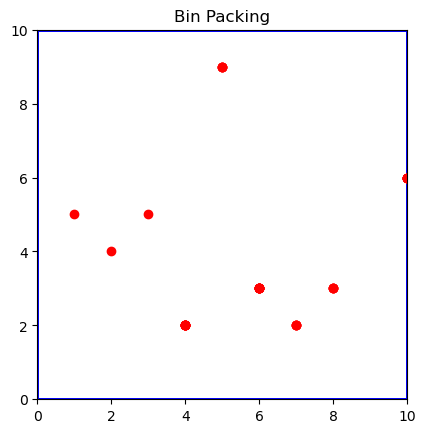

In [6]:
bin_width, bin_height, items = read_dataset('instance2dBIN.txt')
num_bins = fbs_heuristic(bin_width, bin_height, items)
bins = [(bin_height, items[i:i+num_bins]) for i in range(0, len(items), num_bins)]
visualize_packing(bin_width, bin_height, items, bins)

the visualize_packing function creates a visualization of the packing solution. It plots the bins as blue rectangles and the packed items as red dots. The read_dataset and fbs_heuristic functions are used to obtain the bin dimensions, items, and the number of bins used.

### Recherche locale 

In [12]:
def local_search(bin_width, bin_height, items, max_iterations=1000):
    # Initialize the solution with a random placement of items
    solution = [(random.randint(0, bin_width - 1), random.randint(0, bin_height - 1)) for _ in range(len(items))]

    # Evaluate the initial solution
    fitness = evaluate_solution(bin_width, bin_height, items, solution)

    # Perform local search
    for _ in range(max_iterations):
        # Generate a neighbor solution by moving one item to a new location
        neighbor_solution = generate_neighbor(solution, bin_width, bin_height)

        # Evaluate the neighbor solution
        neighbor_fitness = evaluate_solution(bin_width, bin_height, items, neighbor_solution)

        # If the neighbor solution is better, accept it
        if neighbor_fitness < fitness:
            solution = neighbor_solution
            fitness = neighbor_fitness

    return solution

def generate_neighbor(solution, bin_width, bin_height):
    # Select a random item to move
    item_index = random.randint(0, len(solution) - 1)

    # Generate a new location for the item
    new_x = random.randint(0, bin_width - 1)
    new_y = random.randint(0, bin_height - 1)

    # Create a new solution with the item moved to the new location
    neighbor_solution = solution[:item_index] + [(new_x, new_y)] + solution[item_index + 1:]

    return neighbor_solution

def evaluate_solution(bin_width, bin_height, items, solution):
    # Calculate the number of bins used
    bins_used = 0
    for item_index, (item_width, item_height) in enumerate(items):
        x, y = solution[item_index]
        if x + item_width > bin_width or y + item_height > bin_height:
            bins_used += 1

    # Calculate the waste in each bin
    waste = 0
    for item_index, (item_width, item_height) in enumerate(items):
        x, y = solution[item_index]
        waste += (bin_width - x - item_width) * (bin_height - y - item_height)

    # Return the fitness value (number of bins used + waste)
    return bins_used + waste / (bin_width * bin_height)

def visualize_solution(bin_width, bin_height, items, solution):
    fig, ax = plt.subplots()
    ax.set_xlim(0, bin_width)
    ax.set_ylim(0, bin_height)

    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_title('2D Bin Packing Solution')

    for item_index, (item_width, item_height) in enumerate(items):
        x, y = solution[item_index]
        ax.add_patch(plt.Rectangle((x, y), item_width, item_height, fill=False, label=f'Item {item_index}'))

    ax.legend()
    plt.show()


In [13]:
# Load the dataset
bin_width, bin_height, items = read_dataset('instance2dBIN.txt')

# Run the local search algorithm
solution = local_search(bin_width, bin_height, items)

# Print the solution
for item_index, (item_width, item_height) in enumerate(items):
    x, y = solution[item_index]
    print(f'Item {item_index}: ({x}, {y})')

Item 0: (3, 1)
Item 1: (6, 5)
Item 2: (0, 2)
Item 3: (1, 1)
Item 4: (1, 7)
Item 5: (0, 2)
Item 6: (9, 3)
Item 7: (5, 5)
Item 8: (4, 7)
Item 9: (8, 2)
Item 10: (0, 7)
Item 11: (3, 0)
Item 12: (2, 6)
Item 13: (3, 8)
Item 14: (2, 8)
Item 15: (0, 3)
Item 16: (0, 8)
Item 17: (0, 7)


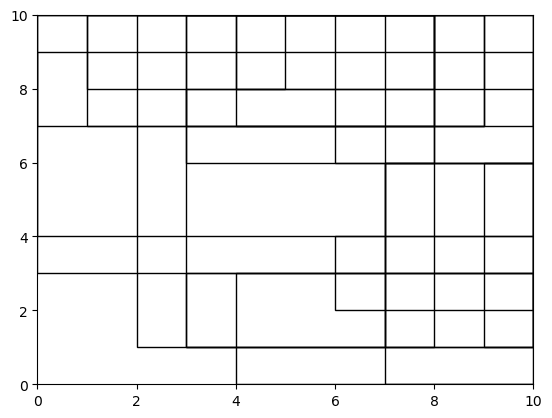

In [14]:
# Run the local search algorithm
solution = local_search(bin_width, bin_height, items)

# Visualize the solution
visualize_solution(bin_width, bin_height, items, solution)